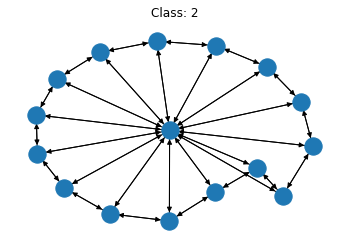

In [7]:
%matplotlib inline
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[28]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title("Class: {:d}".format(label))
plt.show()

In [8]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [10]:
import dgl.function as fn
import torch
import torch.nn as nn

msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    # get mean value from all neighbor
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    # use ReLU(Whv+b) as activation function
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [11]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0289
Epoch 1, loss 1.9344
Epoch 2, loss 1.8384
Epoch 3, loss 1.7477
Epoch 4, loss 1.6701
Epoch 5, loss 1.6071
Epoch 6, loss 1.5127
Epoch 7, loss 1.4330
Epoch 8, loss 1.3478
Epoch 9, loss 1.2899
Epoch 10, loss 1.2326
Epoch 11, loss 1.2182
Epoch 12, loss 1.1537
Epoch 13, loss 1.1268
Epoch 14, loss 1.0742
Epoch 15, loss 1.0338
Epoch 16, loss 0.9934
Epoch 17, loss 1.0077
Epoch 18, loss 1.0338
Epoch 19, loss 0.9647
Epoch 20, loss 0.9458
Epoch 21, loss 0.9292
Epoch 22, loss 0.9269
Epoch 23, loss 0.9486
Epoch 24, loss 0.8853
Epoch 25, loss 0.8857
Epoch 26, loss 0.8561
Epoch 27, loss 0.8447
Epoch 28, loss 0.8416
Epoch 29, loss 0.8162
Epoch 30, loss 0.8053
Epoch 31, loss 0.7919
Epoch 32, loss 0.7910
Epoch 33, loss 0.7914
Epoch 34, loss 0.7917
Epoch 35, loss 0.8692
Epoch 36, loss 0.8527
Epoch 37, loss 0.7965
Epoch 38, loss 0.7461
Epoch 39, loss 0.7802
Epoch 40, loss 0.7506
Epoch 41, loss 0.7438
Epoch 42, loss 0.7250
Epoch 43, loss 0.7476
Epoch 44, loss 0.7322
Epoch 45, loss 0.695

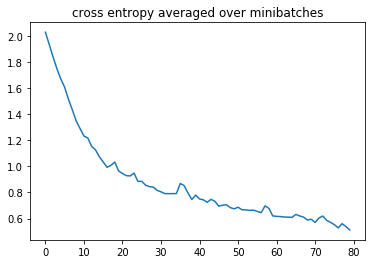

In [13]:
plt.title('cross entropy averaged over minibatches') 
plt.plot(epoch_losses) 
plt.show()

In [14]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 67.5000%
Accuracy of argmax predictions on the test set: 86.250000%


In [15]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 68.7500%
Accuracy of argmax predictions on the test set: 86.250000%
